# Multiclass audio segmentation using `auditok` and GMMs

In [1]:
import wave
import pickle
import numpy as np
from sklearn.mixture import GMM
import librosa
from auditok import DataValidator, ADSFactory, DataSource, StreamTokenizer, BufferAudioSource, player_for
import warnings
warnings.filterwarnings('ignore')

In [74]:
"""
Size of audio window for which MFCC coefficients are calculated
"""
ANALYSIS_WINDOW = 0.02 # 0.02 second = 20 ms

"""
Step of ANALYSIS_WINDOW 
"""
ANALYSIS_STEP = 0.01 # 0.01 second overlap between consecutive windows

"""
number of vectors around the current vector to return.
This will cause VectorDataSource.read() method to return
a sequence of (SCOPE_LENGTH * 2 + 1) vectors (if enough
data is available), with the current vetor in the middle
"""
SCOPE_LENGTH = 25

"""
Number of Mel filters
"""
MEL_FILTERS = 40

"""
Number of MFCC coefficients to keep
"""
N_MFCC = 16

"""
Sampling rate of audio data
"""
SAMPLING_RATE = 44100

"""
ANALYSIS_WINDOW and ANALYSIS_STEP as number of samples
"""
BLOCK_SIZE = int(SAMPLING_RATE * ANALYSIS_WINDOW)
HOP_SIZE = int(SAMPLING_RATE * ANALYSIS_STEP)

"""
Compute delta and delta-delta of MFCC coefficients
"""
DELTA_1 = True
DELTA_2 = True

"""
Where to find data
"""
PREFIX = "data/train"

In [3]:
def extract_mfcc(signal, sr, n_mfcc=16, n_fft=256, hop_length=128, n_mels = 40, delta_1 = True, delta_2 = True):
    #     signal, sr=16000, n_mfcc=16, n_fft=256, hop_length=128, n_mels = 40, delta_1 = False, delta_2 = False
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    if not (delta_1 or delta_2):
        return mfcc.T
    
    feat = [mfcc]
    
    if delta_1:
        mfcc_delta_1 = librosa.feature.delta(mfcc, order=1)
        feat.append(mfcc_delta_1)
    
    if delta_2:
        mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)
        feat.append(mfcc_delta_2)
        
    return np.vstack(feat).T


def file_to_mfcc(filename, sr=44100, **kwargs):
    
    signal, sr = librosa.load(filename, sr = sr)
    
    return extract_mfcc(signal, sr, **kwargs)

In [4]:
class GMMClassifier():
    
    def __init__(self, models):
        """
        models is a dictionary: {"class_of_sound" : GMM_model_for_that_class, ...}
        """        
        self.models = models
    
    def predict(self, data):
        
        result = []
        for cls in self.models:
            
            llk = self.models[cls].score_samples(data)[0]
            llk = np.sum(llk)
            result.append((cls, llk)) 
        
        """
        return classification result as a sorted list of tuples ("class_of_sound", log_likelihood)
        best class is the first element in the list
        """
        return sorted(result, key=lambda f: - f[1])

In [5]:
class ClassifierValidator(DataValidator):
    
    def __init__(self, classifier, target):
        """
        classifier: a GMMClassifier object
        target: string
        """
        self.classifier = classifier
        self.target = target
        
    def is_valid(self, data):
        
        r = self.classifier.predict(data)
        return r[0][0] == self.target

In [6]:
class VectorDataSource(DataSource):
     
    def __init__(self, data, scope=0):
        self.scope = scope
        self._data = data
        self._current = 0
    
    def read(self):
        if self._current >= len(self._data):
            return None
        
        start = self._current - self.scope
        if start < 0:
            start = 0
            
        end = self._current + self.scope + 1
        
        self._current += 1
        return self._data[start : end]
    
    def set_scope(self, scope):
        self.scope = scope
            
    def rewind(self):
        self._current = 0

In [75]:
train_data = {}

a = ["hm1_{:03d}.mp3".format(i) for i in range(3,97)]
train_data["hold"] =a
#train_data["hold"] = ["hm1_003.mp3","hm1_004.mp3","hm1_006.mp3","hm1_007.mp3","hm1_008.mp3","hm1_009.mp3","hm1_010.mp3"]
#print a

train_data["speech"]  = ["speech_1.wav", "speech_2.wav", "speech_3.wav", "speech_4.wav", "speech_5.wav"]
train_data["tring"] = ["r1.wav", "r2.wav", "r3.wav", "r4.wav", "r5.wav", "r6.wav", "r7.wav", "r8.wav", "r9.wav"]

models = {}

# build models
for cls in train_data:

    data = []
    for fname in train_data[cls]:
        data.append(file_to_mfcc(PREFIX + '/' + fname, sr=44100, n_mfcc=N_MFCC, n_fft=BLOCK_SIZE, hop_length=HOP_SIZE, n_mels=MEL_FILTERS, delta_1=DELTA_1, delta_2=DELTA_2))

    data = np.vstack(data)
    
    print("Class '{0}': {1} training vectors".format(cls, data.shape[0]))

    mod = GMM(n_components=3)
    mod.fit(data)
    models[cls] = mod

gmm_classifier = GMMClassifier(models)

# create a validator for each sound class
speech_validator = ClassifierValidator(gmm_classifier, "speech")
tring_validator = ClassifierValidator(gmm_classifier, "tring")
hold_validator = ClassifierValidator(gmm_classifier, "hold")
#print train_data["hold"]


Class 'hold': 9199 training vectors
Class 'speech': 263 training vectors
Class 'tring': 1778 training vectors


### To save model for re-use in future

In [ ]:
# # if you wan to save models
# for cls in train_data:
#     fp = open("models/%s.gmm" % (cls), "wb")
#     pickle.dump(models[cls], fp, pickle.HIGHEST_PROTOCOL)
#     fp.close()


### Transform our audio to be analyzed into a sequence of vectors
Transform the audio stream we want to analyze into a sequence of **MFCC** vectors. 
Use the sequence of **MFCC** vectors to create a **VectorDataSource** object that will make it possible to read a vector and its surrounding context(preceeding and following frames) if required:

In [73]:
# transform audio stream to be analyzed into a sequence of MFCC vectors
# create a DataSource object using MFCC vectors
mfcc_data_source = VectorDataSource(data=file_to_mfcc("data/test.wav",
                                                      44100, n_mfcc=N_MFCC,
                                                      n_fft=BLOCK_SIZE, hop_length=HOP_SIZE,
                                                      n_mels=MEL_FILTERS, delta_1=DELTA_1,
                                                      delta_2=DELTA_2), scope=SCOPE_LENGTH)
print mfcc_data_source

### Initialize the tokenizer object
We will use the same tokenizer object all over our tests. We however need to set a different validator to track a particular sound class (examples below).

In [38]:
# create a tokenizer
analysis_window_per_second = 1. / ANALYSIS_STEP

min_seg_length = 0.1 # second, min length of an accepted audio segment
max_seg_length = 3 # seconds, max length of an accepted audio segment
max_silence = 0.01 # second, max length tolerated of tolerated continuous signal that's not from the same class

# tokenizer = StreamTokenizer(validator=speech_validator, min_length=int(min_seg_length * analysis_window_per_second),
#                                 max_length=int(max_seg_length * analysis_window_per_second),
#                                 max_continuous_silence= max_silence * analysis_window_per_second, mode = 0)
#         mode = StreamTokenizer.DROP_TRAILING_SILENCE)

In [80]:
# read all audio data from stream
# wfp = wave.open("data/test.wav")
#wfp = wave.open("data/test.wav")
wfp = wave.open("data/JeffSample.wav")
audio_data = wfp.readframes(-1)
width = wfp.getsampwidth()
wfp.close()

# data as numpy array will be used to plot signal
fmt = {1: np.int8 , 2: np.int16, 4: np.int32}
signal = np.array(np.frombuffer(audio_data, dtype=fmt[width]), dtype=np.float64)

### Define plot function

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 24, 24

def plot_signal_and_segmentation(signal, sampling_rate, segments=[]):
    _time = np.arange(0., np.ceil(float(len(signal))) / sampling_rate, 1./sampling_rate )
    if len(_time) > len(signal):
        _time = _time[: len(signal) - len(_time)]
    
    pylab.subplot(211)

    for seg in segments:
        
        fc = seg.get("fc", "g")
        ec = seg.get("ec", "b")
        lw = seg.get("lw", 2)
        alpha = seg.get("alpha", 0.4)
        
        ts = seg["timestamps"]
        
        # plot first segmentation outside loop to show one single legend for this class
        p = pylab.axvspan(ts[0][0], ts[0][1], fc=fc, ec=ec, lw=lw, alpha=alpha, label = seg.get("title", ""))
        
        for start, end in ts[1:]:
            p = pylab.axvspan(start, end, fc=fc, ec=ec, lw=lw, alpha=alpha)
            
            
    pylab.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
            borderaxespad=0., fontsize=22, ncol=2)
    
    pylab.plot(_time, signal)
    
    pylab.xlabel("Time (s)", fontsize=22)
    pylab.ylabel("Signal Amplitude", fontsize=22)
    pylab.show()


### Read and plot manual annotations (used for visualization an comparison purposes)

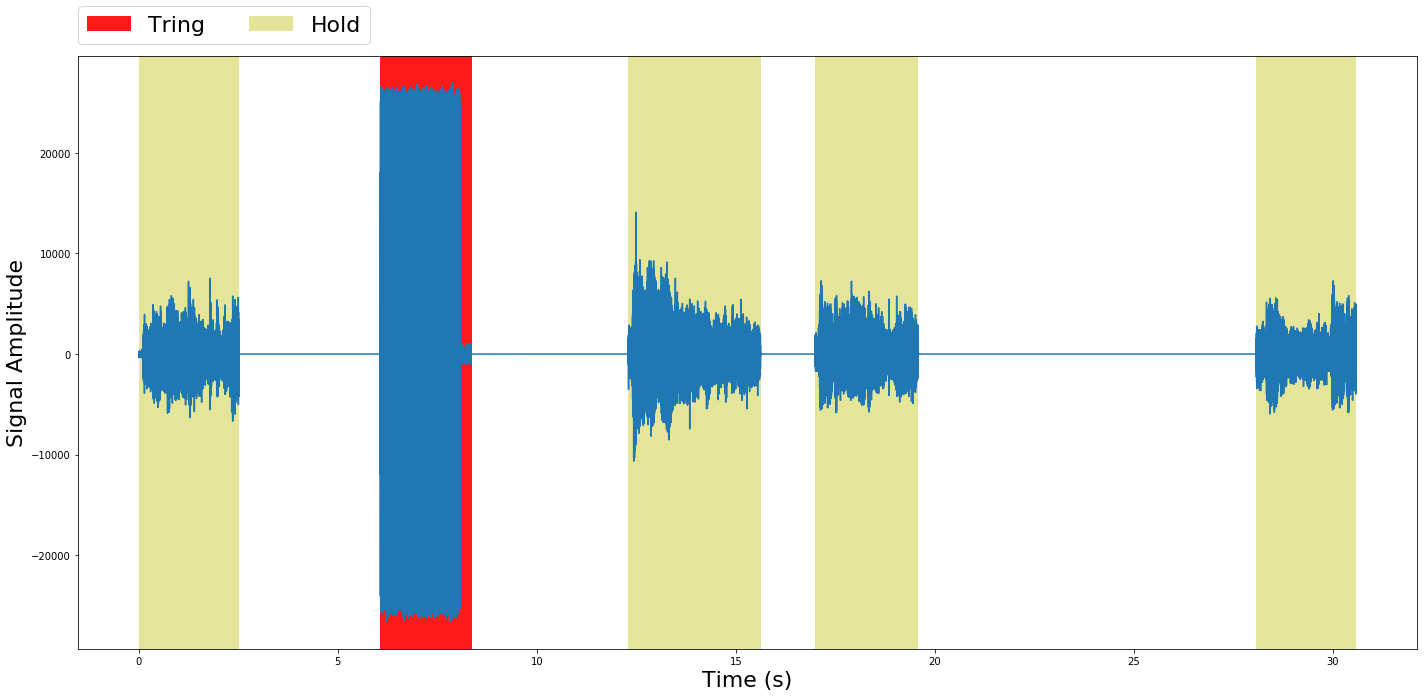

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 24, 24

annotations = {}


ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("data/hold.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["hold"] = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "Hold", "timestamps" : ts}

ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("data/tring.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["tring"] = {"fc" : "r", "ec" : "r", "lw" : 0, "alpha" : 0.9, "title" : "Tring", "timestamps" : ts}


def plot_annot():
    plot_signal_and_segmentation(signal, SAMPLING_RATE,
                             [annotations["tring"],
                              annotations["hold"]])

plot_annot()

## Try out the the first segmentation with hold_machine class
Now, let us start off with a somehow *easy* class.  It is easy to distinguish from our other classes, even with absolute frame-level validation (i.e. no context, `scope = 0`)

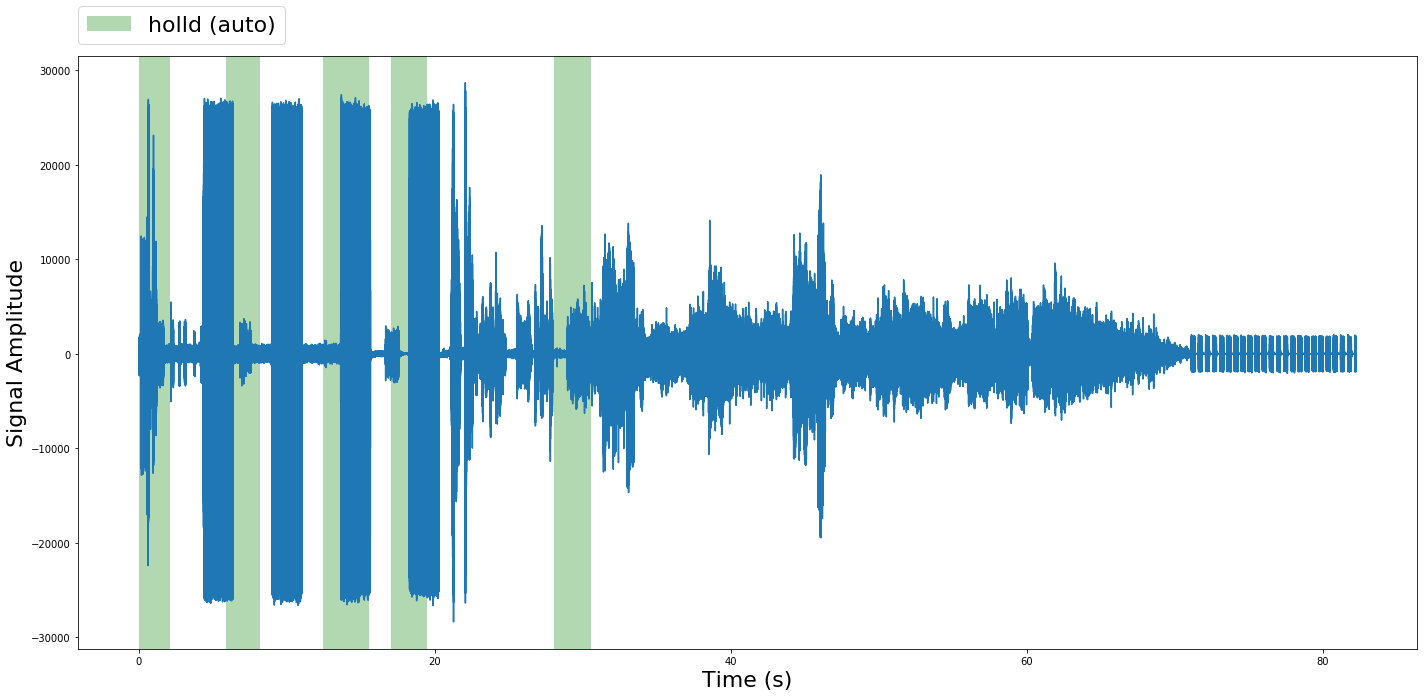

In [82]:
#changed it validator here: 
# change values here
tokenizer = StreamTokenizer(validator=hold_validator, min_length= int(0.5 * analysis_window_per_second),
                                max_length=int(15 * analysis_window_per_second),
                                max_continuous_silence= 0.3 * analysis_window_per_second,
                                mode = StreamTokenizer.DROP_TRAILING_SILENCE)
tokenizer.validator = hold_validator
mfcc_data_source.rewind()
mfcc_data_source.scope = 25
tokens = tokenizer.tokenize(mfcc_data_source)
# print tokens
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
np.savetxt("/home/vivek/Desktop/ts_viv_hold.csv", ts, delimiter=",")

seg = {"fc" : "g", "ec" : "g", "lw" : 0, "alpha" : 0.3, "title" : "holld (auto)", "timestamps" : ts}

plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])

^ result is bad.

In [ ]:
import json
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 24, 24

tokenizer.validator = hold_validator
mfcc_data_source.rewind()
mfcc_data_source.scope = 0
tokens = tokenizer.tokenize(mfcc_data_source)
#print (tokens)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
np.savetxt("/home/vivek/Desktop/ts.csv", ts, delimiter=",")
seg = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "hold (auto)", "timestamps" : ts}
print type(seg)
json.dump(seg, open("/home/vivek/Desktop/segtext.txt",'w'))
#np.savetxt("/home/vivek/Desktop/seg.csv", seg, delimiter=",")
plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])

In [ ]:
mfcc_data_source.rewind()
mfcc_data_source.scope = 15
tokens = tokenizer.tokenize(mfcc_data_source)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]

seg = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "hold (auto)", "timestamps" : ts}
plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])

In [ ]:
segments = []
mfcc_data_source.scope = 25

# track speech
mfcc_data_source.rewind()
tokenizer.validator = tring_validator
tokens = tokenizer.tokenize(mfcc_data_source)
speech_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "r", "ec" : "r", "lw" : 0, "alpha" : 0.4, "title" : "Speech (auto)", "timestamps" : speech_ts}
segments.append(seg)


# track breath
mfcc_data_source.rewind()
tokenizer.validator = hold_validator
tokens = tokenizer.tokenize(mfcc_data_source)
breath_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "Breath (auto)", "timestamps" : breath_ts}
segments.append(seg)



# plot automatic segmentation
plot_signal_and_segmentation(signal, SAMPLING_RATE, segments)

# plot manual segmentation
plot_annot()